### import modules 

In [15]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
sns.set()

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### define functions 

In [5]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))



### load in data

In [27]:
########################################################################
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

IndexError: index 1 is out of range for dimension 0 (of size 1)

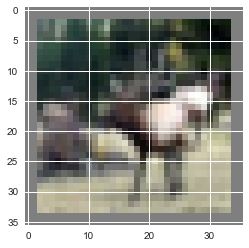

In [28]:
########################################################################
# Let us show some of the training images, for fun.

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [29]:
########################################################################
# 2. Define a Convolution Neural Network
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Copy the neural network from the Neural Networks section before and modify it to
# take 3-channel images (instead of 1-channel images as it was defined).


class Net_simple(nn.Module):
    def __init__(self):
        super(Net_simple, self).__init__()
        self.fc1 = nn.Linear(10, 3072)


    def forward(self, x):
        x = x.resize(3072,1)
        x = self.fc1(x)
        return x


net = Net_simple()

In [34]:
inputs.resize(3072,1)

Variable containing:
 0.0667
 0.0902
 0.1059
   ⋮    
-0.6706
-0.7333
-0.7569
[torch.FloatTensor of size 3072x1]

In [31]:
########################################################################
# 3. Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Let's use a Classification Cross-Entropy loss and SGD with momentum


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

########################################################################
# 4. Train the network
# ^^^^^^^^^^^^^^^^^^^^
#
# This is when things start to get interesting.
# We simply have to loop over our data iterator, and feed the inputs to the
# network and optimize

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

AttributeError: 'Variable' object has no attribute 'shape'

In [1]:
########################################################################
# 5. Test the network on the test data
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# We have trained the network for 2 passes over the training dataset.
# But we need to check if the network has learnt anything at all.
#
# We will check this by predicting the class label that the neural network
# outputs, and checking it against the ground-truth. If the prediction is
# correct, we add the sample to the list of correct predictions.
#
# Okay, first step. Let us display an image from the test set to get familiar.

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

########################################################################
# Okay, now let us see what the neural network thinks these examples above are:

outputs = net(Variable(images))

########################################################################
# The outputs are energies for the 10 classes.
# Higher the energy for a class, the more the network
# thinks that the image is of the particular class.
# So, let's get the index of the highest energy:
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

########################################################################
# The results seem pretty good.
#
# Let us look at how the network performs on the whole dataset.

correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

########################################################################
# That looks waaay better than chance, which is 10% accuracy (randomly picking
# a class out of 10 classes).
# Seems like the network learnt something.
#
# Hmmm, what are the classes that performed well, and the classes that did
# not perform well:

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

########################################################################
# Okay, so what next?
#
# How do we run these neural networks on the GPU?
#
# Training on GPU
# ----------------
# Just like how you transfer a Tensor on to the GPU, you transfer the neural
# net onto the GPU.
# This will recursively go over all modules and convert their parameters and
# buffers to CUDA tensors:
#
# .. code:: python
#
#     net.cuda()
#
#
# Remember that you will have to send the inputs and targets at every step
# to the GPU too:
#
# ::
#
#         inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
#
# Why dont I notice MASSIVE speedup compared to CPU? Because your network
# is realllly small.
#
# **Exercise:** Try increasing the width of your network (argument 2 of
# the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
# they need to be the same number), see what kind of speedup you get.
#
# **Goals achieved**:
#
# - Understanding PyTorch's Tensor library and neural networks at a high level.
# - Train a small neural network to classify images
#
# Training on multiple GPUs
# -------------------------
# If you want to see even more MASSIVE speedup using all of your GPUs,
# please check out :doc:`data_parallel_tutorial`.
#
# Where do I go next?
# -------------------
#
# -  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
# -  `Train a state-of-the-art ResNet network on imagenet`_
# -  `Train an face generator using Generative Adversarial Networks`_
# -  `Train a word-level language model using Recurrent LSTM networks`_
# -  `More examples`_
# -  `More tutorials`_
# -  `Discuss PyTorch on the Forums`_
# -  `Chat with other users on Slack`_
#
# .. _Train a state-of-the-art ResNet network on imagenet: https://github.com/pytorch/examples/tree/master/imagenet
# .. _Train an face generator using Generative Adversarial Networks: https://github.com/pytorch/examples/tree/master/dcgan
# .. _Train a word-level language model using Recurrent LSTM networks: https://github.com/pytorch/examples/tree/master/word_language_model
# .. _More examples: https://github.com/pytorch/examples
# .. _More tutorials: https://github.com/pytorch/tutorials
# .. _Discuss PyTorch on the Forums: https://discuss.pytorch.org/
# .. _Chat with other users on Slack: http://pytorch.slack.com/messages/beginner/

Files already downloaded and verified
horse   car   car horse
[1,  2000] loss: 2.211
[1,  4000] loss: 1.869
[1,  6000] loss: 1.687
[1,  8000] loss: 1.574
[1, 10000] loss: 1.540
[1, 12000] loss: 1.486
[2,  2000] loss: 1.419
[2,  4000] loss: 1.392
[2,  6000] loss: 1.370
[2,  8000] loss: 1.339
[2, 10000] loss: 1.315
[2, 12000] loss: 1.283
Finished Training
GroundTruth:    cat  ship  ship plane
Predicted:    cat   car   car plane
Accuracy of the network on the 10000 test images: 53 %
Accuracy of plane : 57 %
Accuracy of   car : 85 %
Accuracy of  bird : 50 %
Accuracy of   cat : 25 %
Accuracy of  deer : 40 %
Accuracy of   dog : 44 %
Accuracy of  frog : 64 %
Accuracy of horse : 62 %
Accuracy of  ship : 61 %
Accuracy of truck : 40 %
